## 통계 활용대회
### 토픽모델링을 통한 고용형태 변화 탐색

#### - 주요 패키지와 데이터 불러오기

In [27]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# 글씨체
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/H2HDRM.TTF').get_name()
rc('font', family=font_name)

# 데이터 불러오기 각각 19년 20년 기사
data2019 = pd.read_excel('2019gisa.xlsx')
data2020 = pd.read_excel('2020gisa.xlsx')

# text 형식의 데이터 list 형태로 바꿔 주기
data2019['words'] = [i.replace("'", "").replace('[', '').replace(']', '').replace(' ', '').split(',') for i in
                     list(data2019['words'])]  # words가 텍스트 형식으로 되어 있을 경우
data2020['words'] = [i.replace("'", "").replace('[', '').replace(']', '').replace(' ', '').split(',') for i in
                     list(data2020['words'])]  # words가 텍스트 형식으로 되어 있을 경우

#### - 분석대상 키워드 별로 기사량 확인하기

In [2]:
# 분석대상 키워드 (분석대상 키워드는 통계청 뉴스기반 검색사이트를 사용하여 임의로 정했음)
keyword_list = ['유통', '청년', '근로자', '노동자', '배달', '재택근무',
                '화상회의', '택배', '출퇴근', '유연근무제']

# 키워드별 기사량 증감율 확인하기
# 년도별 키워드별 기사량 확인하기
count2019 = []
for k in keyword_list:
    j = 0
    for i in data2019['words']:
        if k in i:
            j += 1
    count2019.append(j)

count2020 = []
for k in keyword_list:
    j = 0
    for i in data2020['words']:
        if k in i:
            j += 1
    count2020.append(j)

keyword_data = pd.DataFrame({'keyword': keyword_list, 'count2019': count2019, 'count2020': count2020})
keyword_data['rate'] = [(i - j) / j for i, j in zip(count2020, count2019)]  # 증가율 계산하기

keyword_data

,keyword,count2019,count2020,rate
0,유통,2683,2579,-0.038763
1,청년,1675,1427,-0.148060
2,근로자,1178,1922,0.631579
3,노동자,736,1220,0.657609
4,배달,522,1347,1.580460
5,재택근무,7,1543,219.428571
6,화상회의,19,739,37.894737
7,택배,254,611,1.405512
8,출퇴근,291,478,0.642612
9,유연근무제,49,115,1.346939


#### - 증감율 시각화 하기

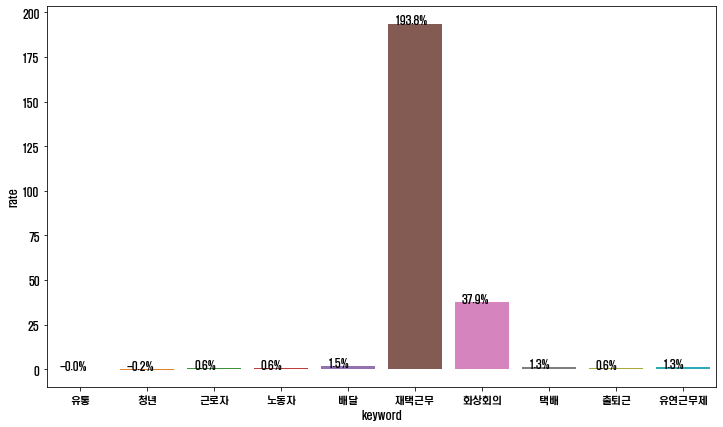

In [14]:
# 그래프를 그려 증감율 확인하기
plt.figure(figsize=(12,7))
plt.plot()
g = sns.barplot(x=keyword_data['keyword'], y=keyword_data['rate'])
for i, j in enumerate(keyword_data['rate']):
    g.text(x=i - 0.3, y=j, s="{:.1f}%".format(j))

#### - 키워드에 따른 뉴스 분류를 위해 (1) 사전방식 을 이용

In [3]:
# 키워드에 따른 뉴스분류를 사전방식과 word2vec 방법을 이용
# 사전 방식으로 뉴스 분류 (포함어 방식)
for i in keyword_list:
    data2019[i] = 0
    data2020[i] = 0

# 뉴스 기사에 키워드가 있으면 1, 아니면 0으로 라벨링
for i in keyword_list:
    for j in range(len(data2019)):
        if i in data2019['words'][j]:
            data2019[i][j] = 1
    for j in range(len(data2020)):
        if i in data2020['words'][j]:
            data2020[i][j] = 1

# 잘 되었는지 확인
print(data2019['청년'].value_counts())
print(data2020['청년'].value_counts())

<ipython-input-3-f3365f346ef3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2019[i][j] = 1
<ipython-input-3-f3365f346ef3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2020[i][j] = 1


0    59051
1     1675
Name: 청년, dtype: int64
0    62234
1     1427
Name: 청년, dtype: int64


#### - word2vec 모델 만들기

In [4]:
# word2vec 분석하기
from gensim.models import KeyedVectors
try:
    embedding_model = KeyedVectors.load_word2vec_format("new_w2v")  # 모델 로드
except:
    embedding_model = Word2Vec(pd.concat([data2020['words'], data2019['words']]), vector_size=100, window=5,
                               min_count=30,
                               workers=4, epochs=50)
    embedding_model.wv.save_word2vec_format('new_w2v')  # 모델 저장

In [14]:
pd.concat([data2020['words'], data2019['words']])
try:
    print(embedding_model.wv.index_to_key)
except:
    print(embedding_model.index_to_key)

['코로나', '서울', '경제', '기업', '지역', '금지', '한국', '지원', '사업', '진자', '정부', '투자', '시장', '대한', '진행', '상황', '제공', '미국', '국내', '최근', '증가', '계획', '사회', '감염', '지난해', '방역', '기준', '발생', '산업', '확산', '현재', '관계자', '대상', '금융', '중국', '서비스', '추가', '운영', '세계', '기록', '조사', '개발', '검사', '관련', '확대', '센터', '관리', '매출', '거래', '판매', '통해', '분석', '신종', '결과', '전망', '감소', '환자', '설명', '확인', '감염증', '시설', '시간', '저작권', '대표', '업체', '기술', '규모', '경기', '코로나바이러스', '가장', '이후', '기간', '발표', '성장', '해외', '수출', '수준', '평가', '고객', '마스크', '시작', '하락', '확진', '직원', '제품', '모두', '이용', '온라인', '가격', '상승', '주가', '가운데', '사람', '영업', '대비', '경우', '추진', '생산', '기관', '정책', '이번', '올해', '영향', '참여', '일본', '종목', '예상', '조치', '상품', '증권', '삼성', '전국', '판정', '우려', '병원', '글로벌', '대응', '대책', '사용', '전자', '행사', '문제', '교육', '정보', '우리', '실적', '지속', '개월', '안전', '신규', '업계', '마련', '부산', '가능성', '사태', '거리', '의료', '대구', '격리', '이상', '그룹', '은행', '예정', '개선', '수요', '활용', '생활', '방문', '활동', '회사', '때문', '다른', '국가', '유지', '기존', '회장', '진단', '치료', '경찰', '부터', '공급', '교회', '현장', '피해',

In [24]:

# 기사들이 해당 키워드와 얼마나 관련이 있는지 점수를 매기는 함수 word2vec 유사도 점수를 활용
def scoring(word, keyword):
    avg_dist = []
    dist = []
    dist_dist = []
    for i in tqdm(range(len(word))):
        for k in word[i]:
            try:
                # 비교하여 similarity 구하기
                dist_dist.append(embedding_model.similarity(keyword, k))  # 그냥 similarity 일때가 있고 wv.similarity 일때가 있다.
            except:
                dist_dist.append(0)
            dist.append(np.array(dist_dist))
            dist_dist = []
        avg_dist.append(np.mean(dist))
        dist = []
    return avg_dist


for i in keyword_list:
    globals()['data2019' + i] = data2019[data2019[i] == 1].reset_index(drop=True)
    globals()['data2019' + i]['score'] = scoring(globals()['data2019' + i]['words'], i)
    globals()['data2020' + i] = data2020[data2020[i] == 1].reset_index(drop=True)
    globals()['data2020' + i]['score'] = scoring(globals()['data2020' + i]['words'], i)
    
data2019청년.head()

  0%|          | 0/2683 [00:00<?, ?it/s]

  0%|          | 0/2579 [00:00<?, ?it/s]

  0%|          | 0/1675 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

  0%|          | 0/1922 [00:00<?, ?it/s]

  0%|          | 0/736 [00:00<?, ?it/s]

  0%|          | 0/1220 [00:00<?, ?it/s]

  0%|          | 0/522 [00:00<?, ?it/s]

  0%|          | 0/1347 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1543 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/611 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

,Unnamed: 0,date,title,text,category,url,words,length_word,유통,청년,근로자,노동자,배달,재택근무,화상회의,택배,출퇴근,유연근무제,score
0,30,2019-03-01,"밑그림 나온 국가교육위원회, 대입제도 고교학점제 등 장기정책 전담","문제는 국회 통과, 전교조 참여 시 야당 반발 가능성유은혜(뒷줄 왼쪽 네 번째) 부...",사회,https://news.naver.com/main/read.nhn?mode=LSD&...,"[문제, 국회, 통과, 전교조, 참여, 야당, 반발, 가능성, 유은혜, 부총리, 교...",353,0,1,0,0,0,0,0,0,0,0,0.086087
1,459,2019-03-02,"'손석희 고소' 프리랜서 기자, 19시간 조사…""증거 냈다""","김씨 측 변호인 ""증거 추가로 제출할 것""폭행치상·협박·명예훼손 등 고소인 신분 손...",사회,https://news.naver.com/main/read.nhn?mode=LSD&...,"[김씨, 변호인, 증거, 추가, 제출, 폭행, 협박, 명예훼손, 고소, 신분, 손석...",245,0,1,0,0,0,0,0,0,0,0,-0.012850
2,540,2019-03-02,"사무금융우분투재단, 사업 아이디어 대국민 공모전",불평등·차별 해소 위한 사업 아이디어 공모…이 달 말까지 접수 전국사무금융서비스노동...,경제,https://news.naver.com/main/read.nhn?mode=LSD&...,"[불평등, 차별, 해소, 사업, 아이디어, 공모, 접수, 전국, 사무, 금융, 서비...",242,0,1,0,0,0,0,0,0,0,0,0.127576
3,584,2019-03-02,"북미대화 결렬에 민대협 ""美, 진정성 있게 대화해라""",진보청년단체 민주주의자주통일대학생협의회(민대협)가 2일 서울 종로구 광화문광장에서 ...,사회,https://news.naver.com/main/read.nhn?mode=LSD&...,"[진보, 청년, 단체, 민주주의자, 주통, 대학생, 협의, 민대협, 서울, 종로구,...",173,0,1,0,0,0,0,0,0,0,0,0.006816
4,617,2019-03-03,"전남도, 해양수산기업 창업부터 육성까지 맞춤형 지원",【무안=황태종 기자】전남도는 해양수산기업의 창업부터 육성까지 맞춤형으로 지원하는 해...,사회,https://news.naver.com/main/read.nhn?mode=LSD&...,"[무안, 황태, 전남도, 해양, 수산기, 창업, 부터, 육성, 맞춤, 지원, 해양,...",218,0,1,0,0,0,0,0,0,0,0,0.141161


10


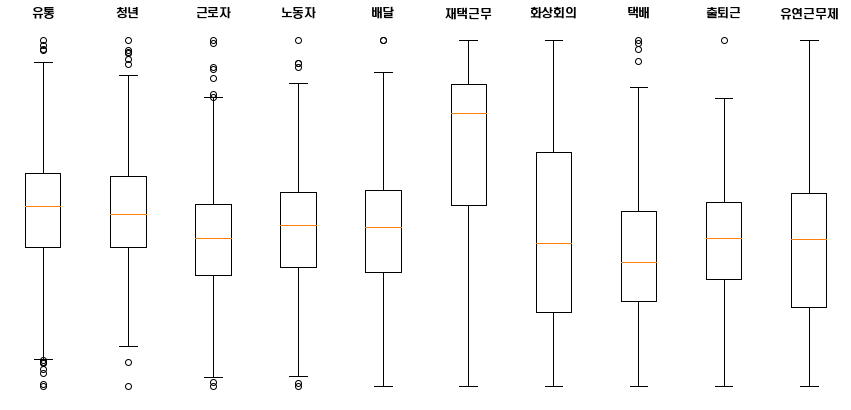

In [44]:
# 카테고리 별로 box plot 그리기
import matplotlib
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/H2HDRM.TTF').get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False  # matplotlib 에 한국어 폰트 적용

print('2019년 boxplot')
plt.figure(figsize=(15,7))
for i,j in enumerate(keyword_list):
    plt.subplot(1,10,i+1)
    plt.boxplot(globals()['data2019' + j]['score'],widths=0.5)
    plt.axis('off')
    plt.title(j)

2020년 boxplot


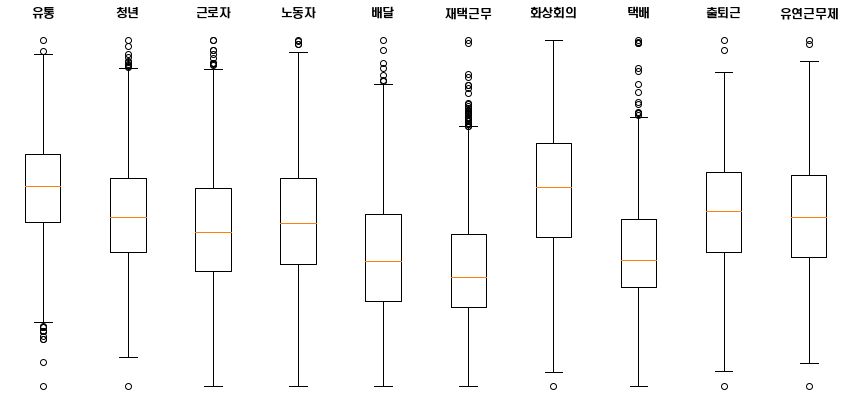

In [45]:
print('2020년 boxplot')
plt.figure(figsize=(15,7))
for i,j in enumerate(keyword_list):
    plt.subplot(1,10,i+1)
    plt.boxplot(globals()['data2020' + j]['score'],widths=0.5)
    plt.axis('off')
    plt.title(j)

In [ ]:
# 이상치 제거 
    q1 = np.percentile(a['score'], 25)
    q3 = np.percentile(a['score'],75)
    iqr = q3-q1
    outlier = q1 -  1.5 * iqr
    print(outlier, ' 값 이하 제거 필요')
    j=0
    for k in a['score']:
        if k < outlier:
            j +=1
    print('이상치 ', j, '개 제거')
    return_data = a[a['score'] > outlier]
    return return_data

#### 각 기사들이 키워드와 얼마나 관련이 있는지 코사인 유사도를 이용해 스코어링

In [ ]:

# 나눠진 데이터 별로 토픽모델링 실시
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

def topic(word):
    texts = word
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]

    def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
        coherence_values = []
        model_list = []
        for num_topics in tqdm(range(start, limit, step)):

            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        return model_list, coherence_values
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2,
                                                            limit=20, step=1)

    # Show graph
    limit = 20; start = 2; step = 1;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    print(coherence_values.index(max(coherence_values)) + 2,'개의 주제가 이상적')
    #print(word)
    #주제 dataframe화 하기
    coherence_values.index(max(coherence_values))
    optimal_model = model_list[coherence_values.index(max(coherence_values))]
    topic_dic = {}
    for i in range(coherence_values.index(max(coherence_values)) + 2):
        words2 = optimal_model.show_topic(i, topn=20)
        topic_dic['topic ' + '{:02d}'.format(i + 1)] = [i[0] for i in words2]
    da = pd.DataFrame(topic_dic)
    return da

a = topic(data2019근로자['words'])

# 나뉘어진 데이터 프레임 별로 토픽모델링
for i in keyword_list:
    globals()['topic2020' + i] = topic(globals()['data2020' + i]['words'])

# 이후 토픽모델링 결과를 살펴보고 고용 트렌드 변화 예측
